# Remote parallel inversion [distributed]

Demo of working inversion (from `grad.ini`) | Brendan Smithyman | May 14, 2015

In [1]:
profile = 'phobos'   # remote workstation
# profile = 'pantheon' # remote cluster
# profile = 'zeus' # remote workstation
# profile = 'mpi' # local machine

In [2]:
from pygeo.segyread import SEGYFile
from pygeo.fullpy import readini

In [3]:
import numpy as np
from zephyr.Problem import SeisFDFD25DParallelProblem
from zephyr.Survey import SeisFDFD25DSurvey
from IPython.parallel import Reference

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 150 # Change this to adjust figure size

# Plotting options
font = {
    'family': 'Bitstream Vera Sans',
    'weight': 'normal',
    'size': 8,
}

matplotlib.rc('font', **font)

In [5]:
lclip = 2000
hclip = 3000
clipscale = 0.1
sms = 0.5
rms = 0.5

def plotField(u):
    clip = clipscale*abs(u).max()
    plt.imshow(u.real, cmap=cm.bwr, vmin=-clip, vmax=clip)

def plotModel(v):
    plt.imshow(v.real, cmap=cm.jet, vmin=lclip, vmax=hclip)

def plotGeometry(geom):
    
    srcpos = geom['src'][:,::2]
    recpos = geom['rec'][:,::2]
    
    axistemp = plt.axis()
    plt.plot(srcpos[:,0], srcpos[:,1], 'kx', markersize=sms)
    plt.plot(recpos[:,0], recpos[:,1], 'kv', markersize=rms)
    plt.axis(axistemp)

# Setup

Input files:

In [6]:
configFile  = 'stacked.ini'
perturbFile = 'Stacked-200x400.gif'
startModel  = 'grad.vp.start'
geom2D      = True

Reading configuration & models:

In [7]:
perturb = plt.imread(perturbFile)[:,:,0].T
perturb = 1 - (perturb - perturb.min()) / (perturb.max() - perturb.min())

In [8]:
c0 = 3000
cPert = +150

ini = readini(configFile)
cFlat = np.ones((ini['nx'], ini['nz'])) * c0
cTrue = cFlat + perturb * cPert

Parameters not set in *.ini* file:

In [9]:
freeSurf    = [False, False, False, False] # t r b l
nPML        = 10            # number of PML points
density     = 2700          # units of density
Q           = 20        # can be inf

cache       = False         # whether to cache computed wavefields for a given source
cacheDir    = '.'

parFac = 1
chunksPerWorker = 1        # NB: parFac * chunksPerWorker = number of source array subsets
ensembleClear = False

In [10]:
rho         = np.ones(cTrue.shape) * density

if geom2D:
    geom        = {
        'src':  np.array([ini['srcs'][:,0], np.zeros(ini['ns']), ini['srcs'][:,1]]).T,
        'rec':  np.array([ini['recs'][:,0], np.zeros(ini['nr']), ini['recs'][:,1]]).T,
        'mode': 'fixed',
    }
else:
    geom        = {
        'src':  ini['srcs'],
        'rec':  ini['recs'],
        'mode': 'fixed',
    }

systemConfig = {
    'dx':       ini['dx'],  # m
    'dz':       ini['dz'],  # m
    'c':        cTrue.T,    # m/s
    'rho':      rho.T,      # density
    'Q':        Q,          # can be inf
    'nx':       ini['nx'],         # count
    'nz':       ini['nz'],         # count
    'freeSurf': freeSurf,   # t r b l
    'nPML':     nPML,
    'geom':     geom,
    'cache':    cache,
    'cacheDir': cacheDir,
    'freqs':    ini['freqs'],
    'nky':      ini['nky'],
    'parFac':   parFac,
    'chunksPerWorker':  chunksPerWorker,
    'profile':  profile,
    'ensembleClear':    ensembleClear,
#     'MPI': False,
#    'Solver':   Reference('SimPEG.SolverWrapD(scipy.sparse.linalg.splu)'),#Solver,
}

In [11]:
%%time
problem = SeisFDFD25DParallelProblem(systemConfig)
survey = SeisFDFD25DSurvey(geom)
survey.pair(problem)

CPU times: user 657 ms, sys: 178 ms, total: 835 ms
Wall time: 16.4 s


Forward modelling 'true' data (in parallel)

In [12]:
%%time
# problem.rebuildSystem(cTrue.T)
problem.forward()
dObs = problem.dPred
problem.dObs = dObs
# uFTrue = problem.uF[2][86]

CPU times: user 7.1 s, sys: 1.81 s, total: 8.91 s
Wall time: 51.2 s


In [13]:
# %%time
# problem.rebuildSystem(cFlat.T)
# problem.forward()
# # uFStart = problem.uF[2][86]

In [14]:
# problem.remote.e0.activate('e0')

In [15]:
# %%pxe0
# dir(endpoint)

In [16]:
# %%px
# print('Rank: %d\n'%(rank,))

# print('\tLocal fields:')
# for key in endpoint.localFields.keys():
#     print('\t\t%s\t%r'%(key, len(endpoint.localFields[key]) if endpoint.localFields[key] is not None else 0.))

# print('\n\tGlobal fields:')
# for key in endpoint.globalFields.keys():
#     print('\t\t%s\t%r'%(key, len(endpoint.globalFields[key]) if endpoint.globalFields[key] is not None else -1))

In [17]:
# %%pxe0
# endpoint.globalFields['dResid'] = endpoint.globalFields['dPred'] - endpoint.globalFields['dObs']

In [18]:
# %%px
# endpoint.globalFields['dResid'] = comm.bcast(endpoint.globalFields['dResid'], 0)

In [19]:
# problem.misfit

In [20]:
# plt.plot([problem.misfit[key] for key in problem.misfit])

In [21]:
# field = uFTrue.real
# clip = 5e-2*abs(field).max()

# x0 = ini['xorig']
# x1 = ini['xorig'] + ini['nx'] * ini['dx']
# z0 = ini['zorig']
# z1 = ini['zorig'] + ini['nz'] * ini['dz']

# plotopts = {
#     'extent':   [x0, x1, z1, z0],
#     'cmap':     cm.bwr,
#     'vmin':     -clip,
#     'vmax':     clip,
# }

# fig = plt.figure()

# plt.subplot(1,2,1)
# plt.imshow(uFTrue.real, **plotopts)
# plt.title('True wavefield')
# plt.xlabel('X [m]')
# plt.ylabel('Z [m]')

# plt.subplot(1,2,2)
# plt.imshow(uFStart.real, **plotopts)
# plt.title('Initial wavefield')
# plt.xlabel('X [m]')
# plt.ylabel('Z [m]')

# fig.tight_layout()

In [22]:
# problem.backprop()

In [23]:
# problem.backpropGraph

Inverting using new `inversion` wrapper, and canned solver (`fmin_cg`, `fmin_l_bfgs_b`, or `fmin_ncg`)

In [24]:
%%time
import inversion
reload(inversion)
sim = inversion.SeisInverseProblem(problem, cFlat.T)
res = sim(solver=inversion.fmin_l_bfgs_b, maxiter=10)

It.	Misfit		fn Eval.
			2.67e+04
  0	2.67e+04
			1.17e+05
			1.99e+05
			2.67e+04
			2.67e+04
			1.30e+05
			2.67e+04
			2.67e+04
			5.81e+04
			2.67e+04
			2.67e+04
			1.99e+04
  1	1.99e+04
			9.64e+03
  2	9.64e+03
			7.93e+03
  3	7.93e+03
			3.96e+03
  4	3.96e+03
			3.14e+03
  5	3.14e+03
			2.03e+03
  6	2.03e+03
			2.08e+03
			2.03e+03
			2.03e+03
			1.90e+03
  7	1.90e+03
			1.77e+03
  8	1.77e+03
			1.52e+03
  9	1.52e+03
			1.35e+03
 10	1.35e+03
			1.18e+03
 11	1.18e+03
			1.02e+03
CPU times: user 3min 10s, sys: 42 s, total: 3min 52s
Wall time: 23min 41s


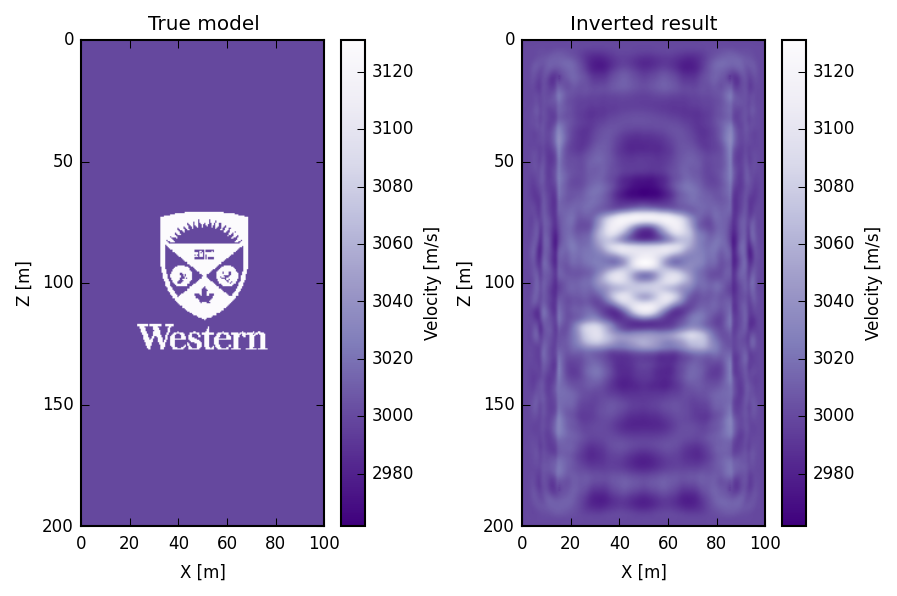

In [25]:
vel = 1./(res[0] if type(res) is tuple else res).reshape(cTrue.T.shape)
x0 = ini['xorig']
x1 = ini['xorig'] + ini['nx'] * ini['dx']
z0 = ini['zorig']
z1 = ini['zorig'] + ini['nz'] * ini['dz']

plotopts = {
    'extent':   [x0, x1, z1, z0],
    'cmap':     cm.Purples_r,
    'vmin':     vel.min(),
    'vmax':     vel.max(),
}

fig = plt.figure()

plt.subplot(1,2,1)
plt.imshow(cTrue.T, **plotopts)
cb = plt.colorbar(orientation='vertical')
plt.title('True model')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
cb.ax.set_ylabel('Velocity [m/s]')

plt.subplot(1,2,2)
plt.imshow(vel, **plotopts)
cb = plt.colorbar(orientation='vertical')
plt.title('Inverted result')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
cb.ax.set_ylabel('Velocity [m/s]')

fig.tight_layout()